# <font  color = "#0093AF">Defaults, Constants, and Tools</font>

SLEEPY relies on a few default settings, numerical constants, and includes a toolbox. These are all found in the main SLEEPY module:
```
sl.Defaults     #Python dictionary containing defaults
sl.Constants    #Python dictionary containing constants
sl.Tools        #Pythong sub-module containing tools
```

These are summarized here

## Setup

In [1]:
# SETUP SLEEPY
import os
os.chdir('../../..')

In [2]:
import SLEEPY as sl
import numpy as np
import matplotlib.pyplot as plt

## Defaults
SLEEPY defaults include data types for real and complex data (`rtype`,`ctype`), whether or not to use parallel processing (`parallel`), whether or not to cache propagators for steps in the rotor cycle (`cache`), the number of cores to use for parallel processing (`ncores`), and whether to print information about calculations (`verbose`).

At the moment, we do not recommend changing the default data types. Numpy does not support higher precision data types for all calculations, and lower precision data types do not result in significant speed up in calculations (although should reduce memory usage). Parallel processing is often not beneficial, as the implemented algorithms in numpy are already fairly optimized for parallel calculations, and parallelism introduces communication overhead. Exceptions may occur for larger powder averages and possibly on different systems. The cache stores propagators for individual steps in the rotor period; it may be turned off if memory usage is too hight. ncores set to None will use all cores available for parallel processing, but an integer may also be provided. Verbosity can be suppressed, especially where many simulations should be performed.

Note that adjusting cache and parallel settings after building a Liouville matrix may result in a propagator cache that is not properly set up.

In [3]:
sl.Defaults

{'rtype': numpy.float64,
 'ctype': numpy.complex128,
 'parallel': False,
 'cache': True,
 'ncores': None,
 'verbose': True}

# Constants

SLEEPY loads a few physical constants for calculations. 

* $h$ = $6.62607015\times10^{-34}$ J$\cdot$s: Planck constant
* $k_B$ = $1.380649\times10^{-23}$ J/K: Boltzmann constant
* $\mu_B$ = $-13996244936.072704$ Hz/T: Bohr magneton
* $g_e$ = $2.00231930436092$ : Free electron g-factor (unitless)
* $\mu_n$ = $7622593.158495312$ Hz/T: Nuclear magneton
* $\mu_0$ = $1.256637\times10^{-6}$ T$^2\cdot$m$^3$/J: Vacuum Permeability

The Planck constant is used to calculate energy from frequencies, and the Boltzmann constant is used with these energies to calculate equilibrium density matrices. The Bohr magneton is used with the free electron g-factor to calculate the electron Gyromagnetic ratio. This is in turn used as reference for the electron carrier frequency. $\mu_0$ is used for calculating dipole couplings.

These constants can be user-adjusted. Note that adjusting $\mu_n$ after loading SLEEPY will *not* affect the nuclear gyromagnetic ratios because these are calculated when SLEEPY loads. However, adjusting $g_e$ will change the electron gyromagnetic ratio and in turn, change the electron carrier frequency (resulting in shifting spectra). Adjustments to $h$ and $k_B$ will affect thermal equilibrium calculations, and adjusting $\mu_0$ will change dipole coupling calculations.

In [4]:
sl.Constants

{'h': 6.62607015e-34,
 'kB': 1.380649e-23,
 'mub': -13996244936.072704,
 'ge': 2.0023193043609235,
 'muen': 5.05078369931e-27}

## Tools

SLEEPY has a variety of tools for help setting up simulations.

### NucInfo
`sl.Tools.NucInfo` provides information about nuclei. It may be indexed (`NucInfo[...]`) with the name of a nucleus, or called as a function. Using the chemical symbol without mass number will return all isotopes of that element. Calling by default returns the gyromagnetic ratio in Hz/T. One may also set `info=...` and request 'gyro', 'mass', 'spin', 'abund', or 'all', which returns a dictionary with all values. For calls (`NucInfo(...)`), if only the chemical symbol is provided ('H', 'N','U', etc.), then it will try to guess the desired nucleus (priority: spin 1/2, non-zero spin, abundance, so 'H'->'1H', 'C'->'13C', 'U'->'235U').

In [5]:
sl.Tools.NucInfo('H')  #Returns 1H gyroratio 

42577478.05321166

In [6]:
sl.Tools.NucInfo('13C',info='all')  #Returns all info about 13C

{'Nuc': 'C',
 'mass': 13.0,
 'spin': 0.5,
 'gyro': 10708398.762252755,
 'abundance': 0.010700000000000001}

In [7]:
sl.Tools.NucInfo['15N']  #Returns all info about 15N (exact match required)

                     0
Nuc                  N
mass              15.0
spin               0.5
gyro        -4317266.6
abundance      0.00368

[1 experiments with 5 parameters]

In [8]:
sl.Tools.NucInfo['O']

                     0           1           2
Nuc                  O           O           O
mass              16.0        17.0        18.0
spin               0.0         2.5         0.0
gyro               0.0  -5774236.2         0.0
abundance   0.99757000  0.00037999  0.00204999

[3 experiments with 5 parameters]

### dipole_coupling
Calculates the dipole coupling between two nuclei (or electron). Input is the distance between the nuclei in Angstroms and the names of the two nuclei. Output is the *anisotropy* (`delta`) of the dipole coupling in Hz, which is twice as big as $D$ which is often referred to as the dipole coupling. If using this function, the output value should be assigned to `delta` when adding a dipole coupling to a system.

e.g.:
```
ex.set_inter('dipole',i0=0,i1=1,delta=sl.Tools.dipole_coupling(.102,'15N','1H'))
```

In [9]:
sl.Tools.dipole_coupling(.109,'1H','13C')

46656.37350022942

### Exchange matrices
Sleepy calculates a number of different exchange matrices. Note that we provide a correlation time to define these matrices. This correlation time is the inverse of the non-zero eigenvalue (or inverse of the mean of the non-zero eigenvalues). This effective correlation time is the correct value to be applied, for example, for model-free calculations.

* twoSite_kex

Two-site exchange with correlation time and optionally populations as input. 

* nSite_sym

Returns an exchange matrix over $n$-sites, where all sites are equally populated, and all exchange rate constants are the same. Input is the number of sites and the correlation time. Note that while there are $n-1$ non-zero eigenvalues to this matrix, all eigenvalues are the same.

* fourSite_sym

Same as above, but specifically for four sites. Usually paired with tetrahedral hopping.

* tumbling

Takes either a 3-site or 4-site symmetric hop, or a "repulsion" powder average, and calculates an exchange matrix to mimic tumbling. The rates are adjusted so that the mean non-zero eigenvalue matches the input correlation time. Also returns Euler angles (usually, not directly used by the user; rather use `sl.Tools.SetupTumbling`, see below). Number of angles is determined by an integer quality factor, `q`. Tumbling does not currently include an average around the $\gamma$-angle.



[1] G. Lipari, A. Szabo. [J. Am. Chem. Soc.](https://doi.org/10.1021/ja00381a010), **1982**, 104, 4559-4579.

In [13]:
print(sl.Tools.twoSite_kex(tc=1e-3,p1=.75))  #Two-site, asymmetric exchange

[[-250.  750.]
 [ 250. -750.]]


In [14]:
print(sl.Tools.nSite_sym(n=5,tc=1e-3))    #Five-site, symmetric exchange

[[-800.  200.  200.  200.  200.]
 [ 200. -800.  200.  200.  200.]
 [ 200.  200. -800.  200.  200.]
 [ 200.  200.  200. -800.  200.]
 [ 200.  200.  200.  200. -800.]]


In [34]:
kex,euler=sl.Tools.tumbling(q=2,tc=1e-3)
for k in kex:
    print(' '.join([f'{k0:6.1f}' for k0 in k]))

-768.1  180.7    0.0  173.4  173.2  119.8    0.0    0.0    0.0  121.0
 180.7 -752.9    0.0    0.0    0.0  180.9   28.9  180.3    0.0  182.2
   0.0    0.0 -753.7  181.6  180.9    0.0  180.8   28.9  181.5    0.0
 173.4    0.0  181.6 -769.3  120.0    0.0  121.3    0.0    0.0  173.1
 173.2    0.0  180.9  120.0 -768.4  173.7    0.0    0.0  120.5    0.0
 119.8  180.9    0.0    0.0  173.7 -768.1    0.0  120.2  173.4    0.0
   0.0   28.9  180.8  121.3    0.0    0.0 -797.5  173.3  119.7  173.4
   0.0  180.3   28.9    0.0    0.0  120.2  173.3 -796.5  173.6  120.2
   0.0    0.0  181.5    0.0  120.5  173.4  119.7  173.6 -768.8    0.0
 121.0  182.2    0.0  173.1    0.0    0.0  173.4  120.2    0.0 -769.9


Note that the eigenvalues of the above matrix are not all identical, but span a fairly small range where the amplitude is significant, making it a good approximation for tumbling. The inverse of the weighted average of the eigenvalues matches the input correlation time (use `kex2A` to verify)

In [38]:
_,_,tc,A=sl.Tools.kex2A(kex,euler)
for tc0,A0 in zip(tc,A):
    print(f'k:{1/tc0:.1f}, A:{A0:.2f}')

k:1171.6, A:0.00
k:1033.0, A:0.18
k:1024.3, A:0.20
k:1012.3, A:0.19
k:1010.6, A:0.19
k:938.9, A:0.24
k:534.8, A:0.00
k:526.2, A:0.00
k:461.6, A:0.00


In [40]:
kavg=((1/tc)*A).sum()
print(1/kavg)

0.001


In [67]:
import matplotlib.pyplot as plt
import numpy as np
from ipywidgets import interact, widgets, HBox, VBox, Layout
from IPython.display import display

# Function to generate a sample plot (replace with your actual plot function)

def sample_plot(x_min, x_max, y_min, y_max):
    ax=plt.subplots()[1]
    x = np.linspace(0, 10, 100)
    y = np.sin(x)
    ax.plot(x,y)
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
#     plt.show()


# Create the sliders
x_min_slider = widgets.FloatSlider(min=0, max=10, step=0.1, value=0, description='X Min')
x_max_slider = widgets.FloatSlider(min=0, max=10, step=0.1, value=10, description='X Max')
y_min_slider = widgets.FloatSlider(min=-1.5, max=1.5, step=0.1, value=-1.5, description='Y Min')
y_max_slider = widgets.FloatSlider(min=-1.5, max=1.5, step=0.1, value=1.5, description='Y Max')

# Place the X Min and X Max sliders in a horizontal box (side by side)
x_slider_box = HBox([x_min_slider, x_max_slider])

# Create an interactive plot with the sliders
interact(sample_plot,
         x_min=x_min_slider,
         x_max=x_max_slider,
         y_min=y_min_slider,
         y_max=y_max_slider)

# # Display the sliders horizontally next to each other
# display(x_slider_box)
# display(y_min_slider)
# display(y_max_slider)

interactive(children=(FloatSlider(value=0.0, description='X Min', max=10.0), FloatSlider(value=10.0, descripti…

<function __main__.sample_plot(x_min, x_max, y_min, y_max)>

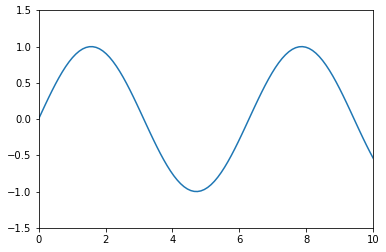

In [83]:
import matplotlib.pyplot as plt
import numpy as np
from ipywidgets import interact, interactive_output, widgets, HBox, VBox, Layout
from IPython.display import display
from copy import copy

fig,ax=plt.subplots()
plt.close(fig)
x = np.linspace(0, 10, 100)
y = np.sin(x)
ax.plot(x,y)


hdisplay=display("",display_id=True)

def zoom(x_min,x_max,y_min,y_max,hdisplay=hdisplay):
    ax.set_xlim((x_min,x_max))
    ax.set_ylim((y_min,y_max))
    hdisplay.update(fig)
#     return x_min,x_max,y_min,y_max

    
# Create the sliders
x_min_slider = widgets.FloatSlider(min=0, max=10, step=0.1, value=0, description='X Min')
x_max_slider = widgets.FloatSlider(min=0, max=10, step=0.1, value=10, description='X Max')
y_min_slider = widgets.FloatSlider(min=-1.5, max=1.5, step=0.1, value=-1.5, description='Y Min')
y_max_slider = widgets.FloatSlider(min=-1.5, max=1.5, step=0.1, value=1.5, description='Y Max')

# Place the X Min and X Max sliders in a horizontal box (side by side)
x_slider_box = HBox([x_min_slider, x_max_slider])
y_slider_box = HBox([y_min_slider, y_max_slider])
slider_box = VBox([x_slider_box,y_slider_box])

# Create an interactive plot with the sliders
q=interactive_output(zoom,{
         'x_min':x_min_slider,
         'x_max':x_max_slider,
         'y_min':y_min_slider,
         'y_max':y_max_slider})

# Display the slider layout (Only this part, interact will handle rest)
display(slider_box)


In [74]:
%matplotlib widget

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as wgs
from ipywidgets import HBox, VBox
%matplotlib inline

def f(A, decay, wd, phase):
    t = np.linspace(0, 2*np.pi, 501)
    fig, ax = plt.subplots(figsize=(14,4), dpi=100)
    x = A*np.exp(-decay*t)*np.sin(wd*t + phase)
    ax.plot(t, x, 'b.', linewidth = 3)
    ax.grid()
    ax.set_title(r'$ %(amp)s e^{ -%(sig)s t} sin( %(wd)s t + %(phi)s ) $' %{'amp':A, 'sig':decay, 'wd':wd, 'phi':phase,} )
    ax.set_xlabel('t')
    ax.set_ylabel('x(t)')
    ax.set_xlabel('Time (seconds)')
    ax.set_ylabel('Displacement (meters)')
    ax.set_xticks(np.linspace(min(t),max(t), 21))
    ax.set_yticks(np.linspace(-A, A,11))  
    return A, decay, wd, phase
A  = wgs.IntSlider(value = 1, min = 1, max = 10, step = 1, description = r'$ A : $', disabled=False)
decay = wgs.FloatSlider(value = 0, min = 0, max = 10, step = 0.5, description = r'$ \sigma : $', disabled=False)
wd    = wgs.IntSlider(value = 1, min = 1, max = 20, step = 1, description = r'$ \omega_d : $', disabled=False)
phase = wgs.FloatSlider(value = 0, min = -1.5, max = 1.5, step = 0.1, description = r'$ \phi : $', disabled=False)
row1 = HBox( [A, decay] )
row2 = HBox( [wd, phase] )
ui = VBox( [row1, row2] )
out = wgs.interactive_output(f, {'A':A, 'decay':decay, 'wd':wd, 'phase':phase} )
display(ui, out)

Output()

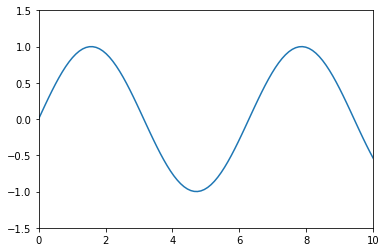

In [51]:
ax.figure

In [55]:
fig=plt.figure()

<Figure size 432x288 with 0 Axes>

In [56]:
fig.add_axes(ax)

ValueError: The Axes must have been created in the present figure

In [57]:
fig=ax.figure

In [60]:
plt.close(fig)

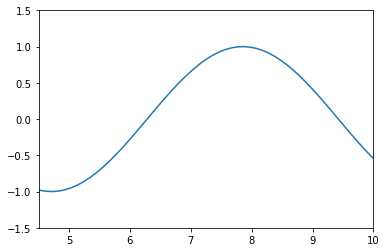

In [61]:
fig

In [63]:
ax.get_children()

 Text(0.5, 1.0, ''),
 Text(0.0, 1.0, ''),
 Text(1.0, 1.0, ''),

In [64]:
kids=ax.get_children()

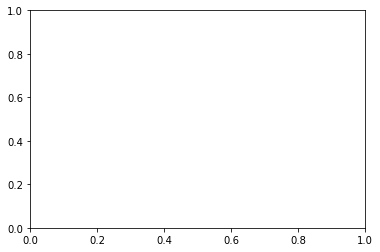

In [65]:
ax1=plt.subplots()[1]